## Predicting Titanic Passenger Survival
The goal of this project is to predict whether a passenger on titanic survived or not based on various features. The data can be find in Kaggle (https://www.kaggle.com/competitions/titanic/).

### Target Variable
The target variable `Survival` is binary:
- 0: the passenger did not survive
- 1: the passenger survived

### Features
- `Pclass`: ticket class
- `Sex`
- `Age`
- `SibSp`: number of siblings/spouses on Titanic
- `Parch`: number of parents/children on Titanic
- `Ticket`
- `Fare`
- `Cabin`
- `Embarked`: port of Embarkation

### Problem Type
This is a binary classification problem, predicting a passenger survived or not.

In [1]:
!pip install seaborn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# drop unnecessary columns
df = df.drop(columns = ['PassengerId', 'Name', 'Ticket', 'Cabin'])

In [7]:
# fill in na with median for Age
median_age = df['Age'].median()
df["Age"].fillna(median_age, inplace=True)

In [8]:
# fill in na with mode for Embarked
mode_embarked = df['Embarked'].mode()[0]
df["Embarked"].fillna(mode_embarked, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


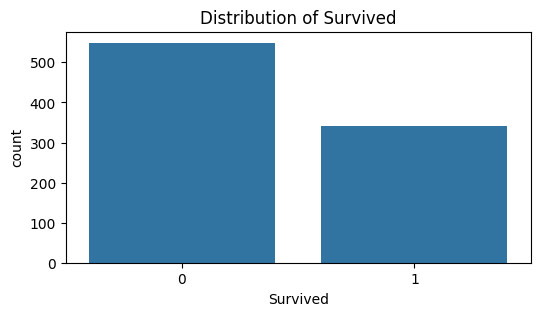

In [10]:
# compare the disturbution of the target variable.
plt.figure(figsize=(6, 3))
sns.countplot(x='Survived', data=df)
plt.title('Distribution of Survived')
plt.show()

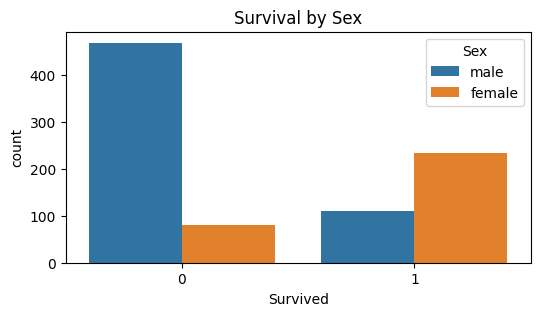

In [11]:
# compare survival by gender
plt.figure(figsize=(6, 3))
sns.countplot(x='Survived', hue='Sex', data=df)
plt.title('Survival by Sex')
plt.show()

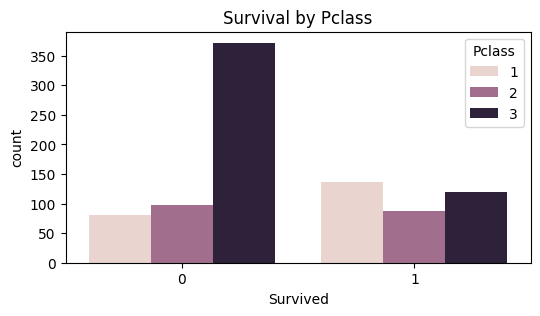

In [12]:
# compare survival by Pclass
plt.figure(figsize=(6, 3))
sns.countplot(x='Survived', hue='Pclass', data=df)
plt.title('Survival by Pclass')
plt.show()

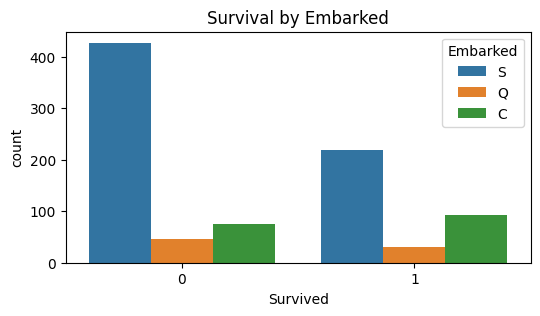

In [13]:
# compare survival by Embarked
plt.figure(figsize=(6, 3))
sns.countplot(x='Survived', hue='Embarked', data=df)
plt.title('Survival by Embarked')
plt.show()

In [14]:
# map 'Sex' column to numeric values (0 for male, 1 for female)
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# map 'Embarked' column to numeric values (0 for C, 1 for Q, 2 for S)
df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

<Axes: >

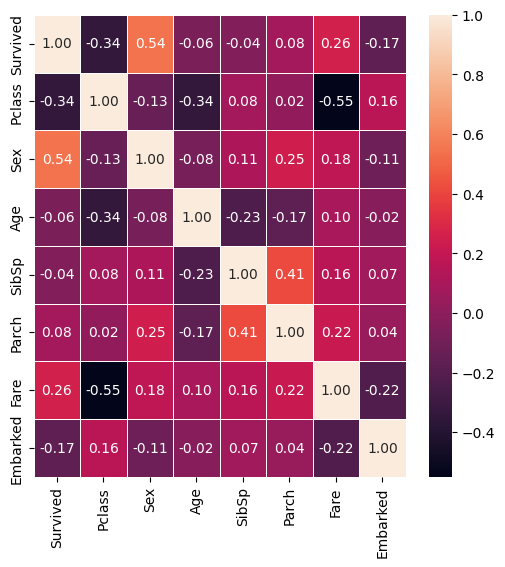

In [15]:
# use heatmap to visualize the correlations.
plt.figure(figsize=(6, 6))
sns.heatmap(df.corr(), annot = True, fmt='.2f', linewidth = 0.5)

In [16]:
class RandomForest:
    def __init__(self, n_learners=20, base=DecisionTreeClassifier(max_depth=3)):
        self.n_learners = n_learners
        self.base = base
        self.learners = []
        
    def fit(self, X_train, y_train):
        for k in range(self.n_learners):
            h = clone(self.base)
            
            features = np.random.choice(X_train.shape[1], size=X_train.shape[1], replace=True)
            h.fit(X_train.iloc[:, features], y_train)
            
            self.learners.append((h, features))
        
        return self
    
    def predict(self, X):
        yhat = np.zeros(X.shape[0])
        
        for h, features in self.learners:
            yhat += h.predict(X.iloc[:, features])
        
        return np.sign(yhat)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
    
    def feature_importance(self, X_train):
        scores = np.zeros(X_train.shape[1])
        
        for h, features in self.learners:
            scores[features] += h.feature_importances_
            
        scores /= len(self.learners)
        return scores

In [17]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [18]:
clf = RandomForest(n_learners = 150, base=DecisionTreeClassifier(max_depth=5))
clf.fit(X_train, y_train)
pred_score = 1 - clf.score(X_test, y_test)

print('Misclassification error on test data : %0.3f'%pred_score)

Misclassification error on test data : 0.402


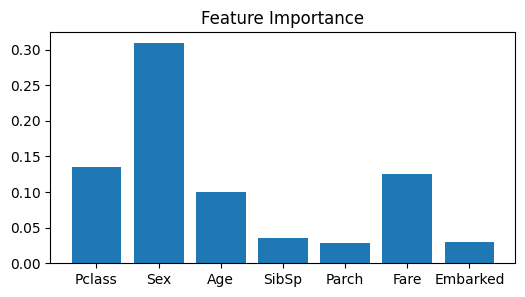

In [19]:
plt.figure(figsize=(6, 3))
feature_importance = clf.feature_importance(X_train)
plt.bar(X_train.columns, feature_importance)
plt.title("Feature Importance")
plt.show()

In [20]:
feature_importance_threshold = 0.1
selected = ['Pclass', 'Sex', 'Age', 'Fare']

X2 = X[selected]
y2 = y
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)

In [21]:
clf2 = RandomForest(n_learners = 150, base=DecisionTreeClassifier(max_depth=5))
clf2.fit(X_train2, y_train2)
pred_score2 = 1 - clf2.score(X_test2, y_test2)

print('Misclassification error on test data : %0.3f'%pred_score2)

Misclassification error on test data : 0.285


This project predicts the survival of Titanic passengers based on various features and utilizing machine learning techiniques. Though data analysis, we gained insights into the factors that may influence the survival, such as Pclass, Sex, Age and Fare. We see that by dropping columns with low feature importance decreases the misclassification error.